In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import joblib 
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif , chi2
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
from sklearn.metrics import f1_score , classification_report , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from imblearn.over_sampling import SMOTE



In [2]:
DATA_PATH = os.path.join(os.getcwd(),'..','dataset','Churn_Modelling.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df = df.drop(columns=['RowNumber','CustomerId','Surname'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


#EDA

In [4]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

* Data visualization & handling outliers

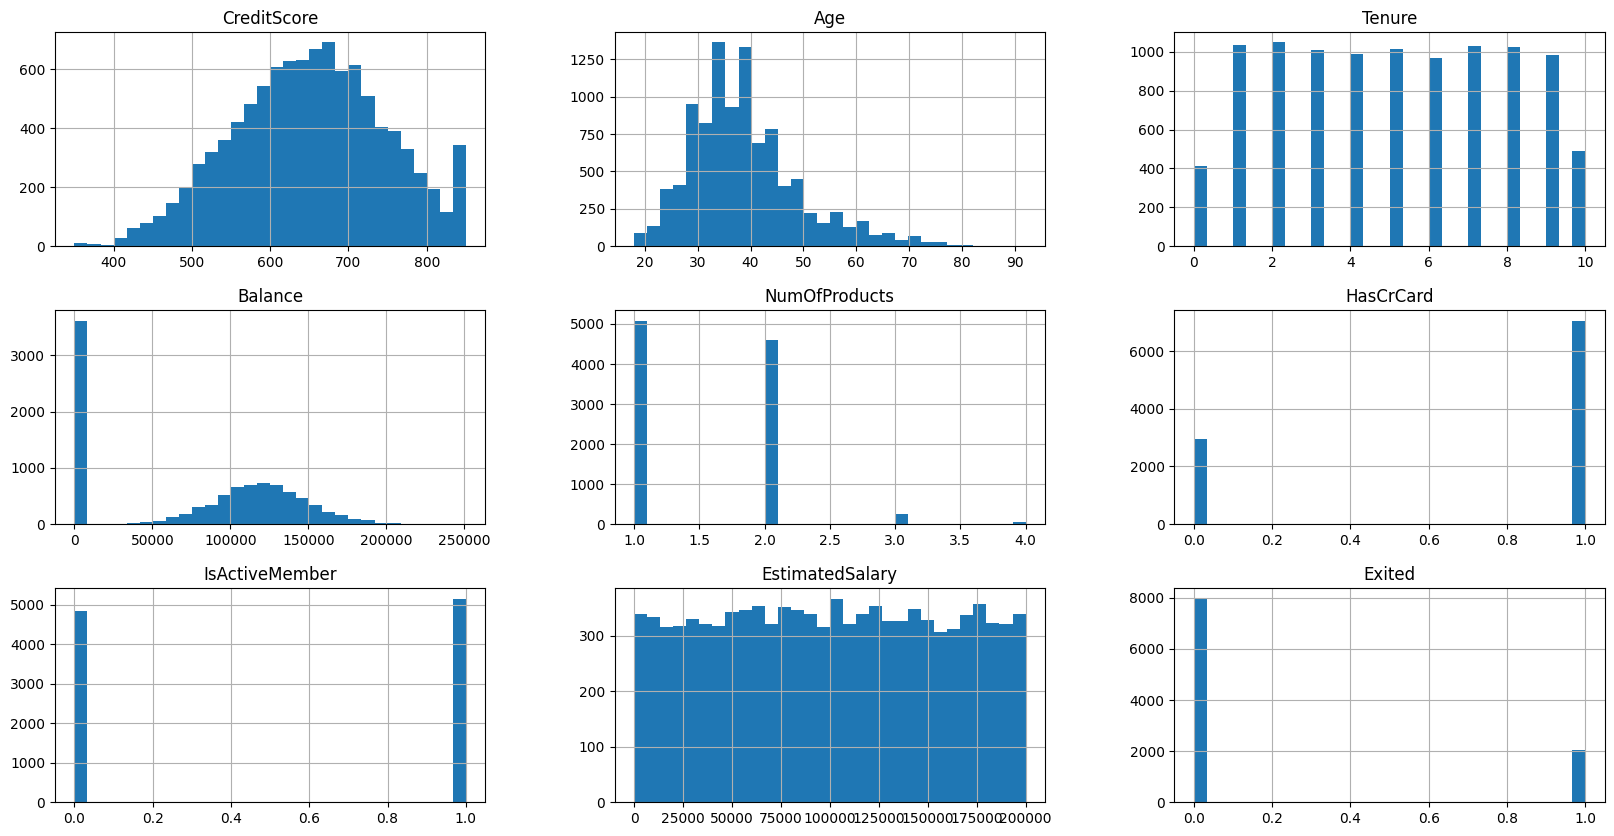

In [7]:
df.hist(bins = 30 , figsize=(20,10))
plt.show()

In [8]:
df[df['Age'] >= 80]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
310,652,France,Female,80,4,0.00,2,1,1,188603.07,0
766,700,France,Female,82,2,0.00,2,0,1,182055.36,0
2458,513,Spain,Male,88,10,0.00,2,1,1,52952.24,0
3033,787,France,Female,85,10,0.00,2,1,1,116537.96,0
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98,0
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
3994,809,Spain,Male,80,8,0.00,2,0,1,34164.05,0
4931,682,Germany,Male,81,6,122029.15,1,1,1,50783.88,0
6443,753,France,Male,92,3,121513.31,1,0,1,195563.99,0
6759,705,France,Male,92,1,126076.24,2,1,1,34436.83,0


In [9]:
df = df.drop(index=df[df['Age']>=80].index)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


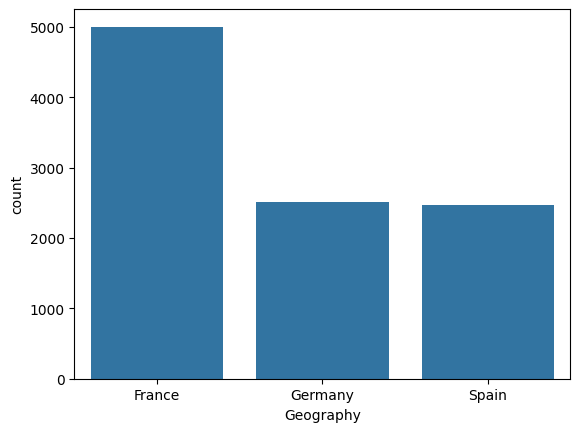

In [11]:
sns.countplot(data=df,x='Geography',order=df['Geography'].value_counts().index.to_list())
plt.show()

<Axes: xlabel='Gender', ylabel='EstimatedSalary'>

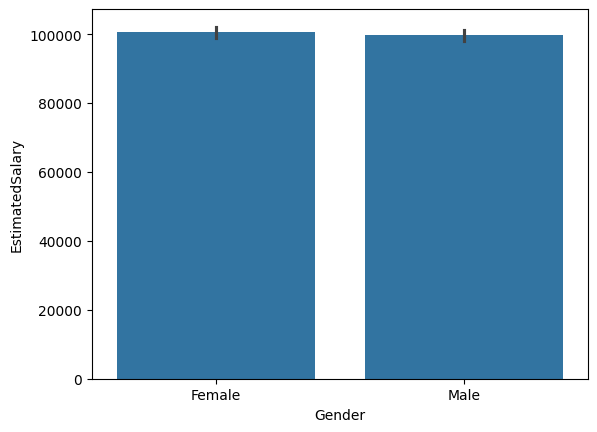

In [12]:
sns.barplot(data = df , x='Gender',y='EstimatedSalary')

In [13]:
df[['Gender','EstimatedSalary']].groupby('Gender')['EstimatedSalary'].mean()

Gender
Female    100556.596233
Male       99690.142441
Name: EstimatedSalary, dtype: float64

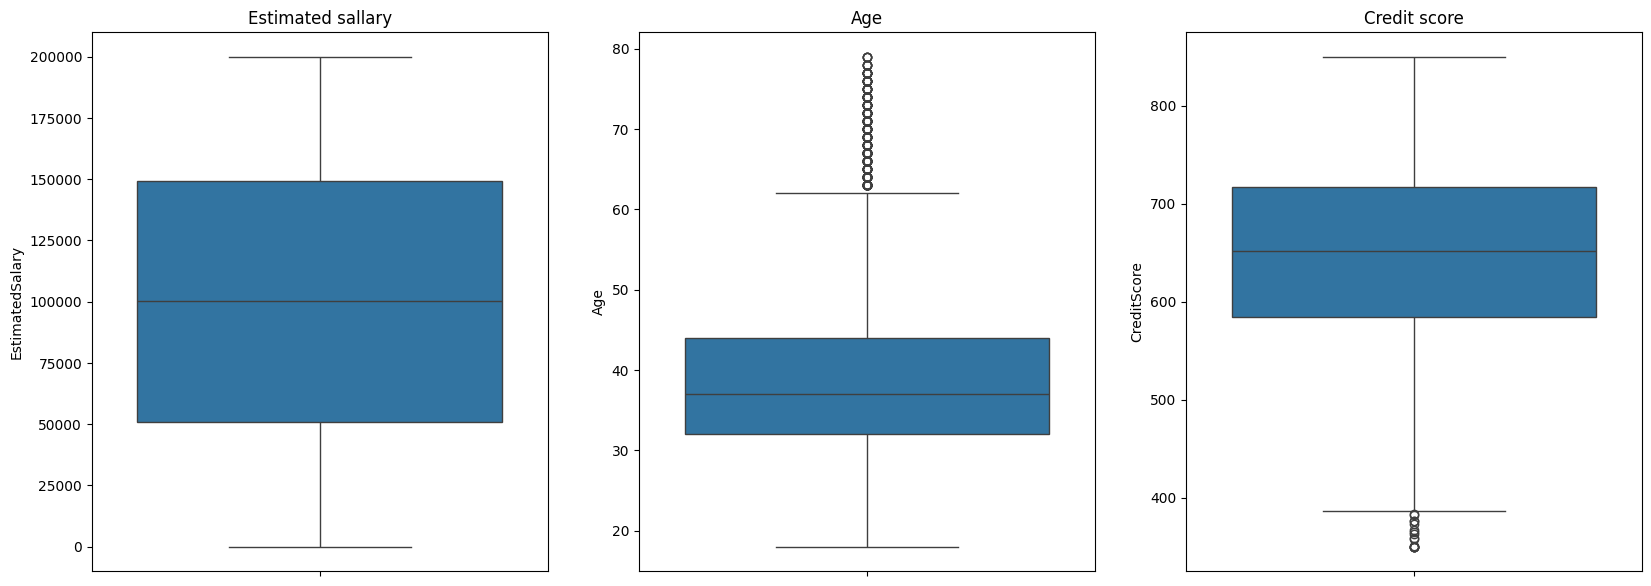

In [14]:
fig , axs = plt.subplots(1,3,figsize=(20,7))

# Estimated sallary outliers
plt.sca(axs[0])
sns.boxplot(data=df , y='EstimatedSalary')
plt.title('Estimated sallary')


# Age outliers
plt.sca(axs[1])
sns.boxplot(data=df , y='Age')
plt.title('Age')

#Credit score outliers
plt.sca(axs[2])
sns.boxplot(data=df , y='CreditScore')
plt.title('Credit score')


plt.show()

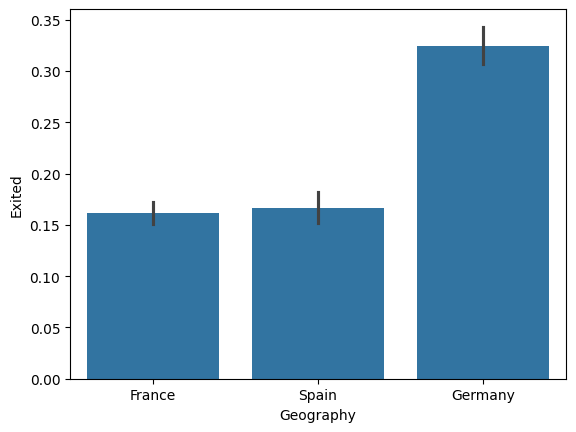

In [15]:
sns.barplot(data = df , x= 'Geography' ,y='Exited')
plt.show()

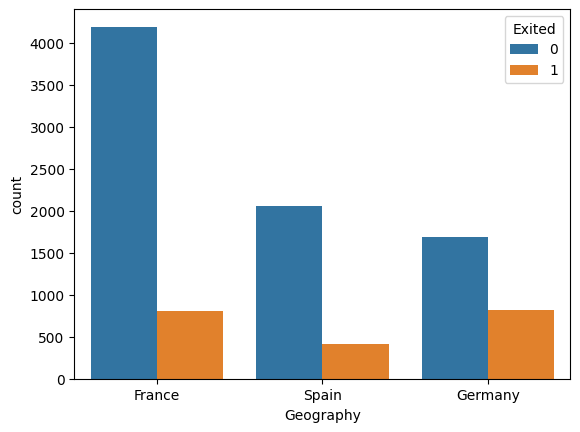

In [16]:
sns.countplot(data=df,x='Geography',hue='Exited')  ## labels, titles
plt.show()

In [17]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [18]:
num_features = ['CreditScore','Age','Balance','EstimatedSalary']
cat_features = ['Gender','Geography']
target_feature = ['Exited']
ready_features = list(set(df.columns.to_list())-set(num_features)-set(cat_features)-set(target_feature))
ready_features

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [19]:
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [20]:
# data split
X= df.drop(columns=['Exited'])
y = df['Exited']

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42 , stratify=y)
print(type(y))

<class 'pandas.core.series.Series'>


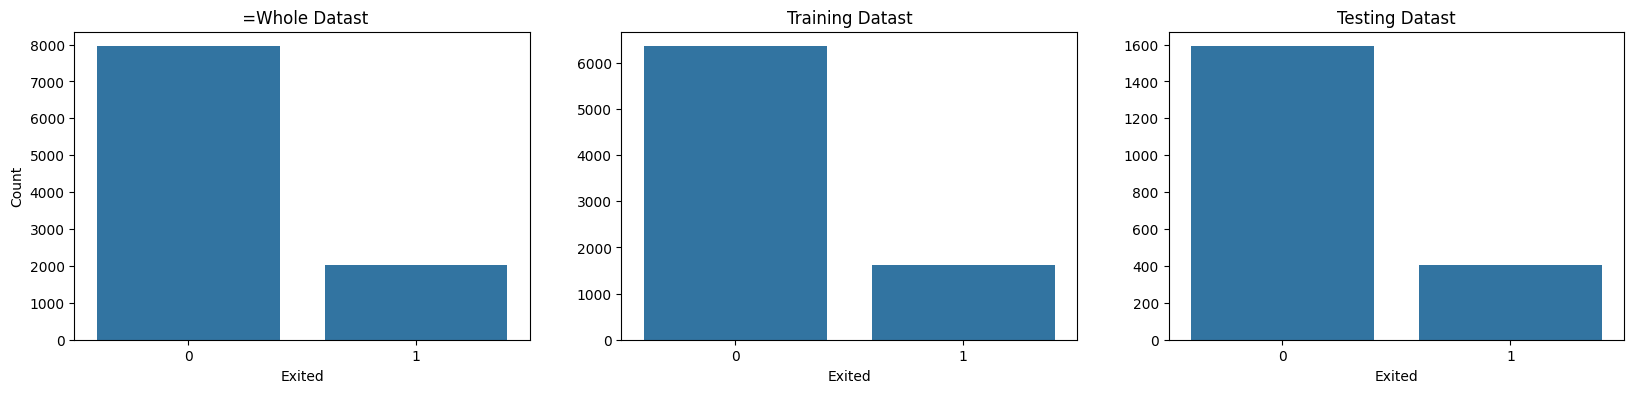

In [21]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title(' =Whole Datast')
plt.ylabel('Count')

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('Training Datast')
plt.ylabel('')

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('Testing Datast')
plt.ylabel('')
plt.show()

In [22]:
# p values for numerical features
_,p_values = f_classif(X=X_train[num_features],y=y_train)
print(p_values)

[1.00799361e-002 8.06719607e-152 9.52107506e-031 3.20639168e-001]


In [23]:
# p values for cat features 
_,p_values = chi2(X=OrdinalEncoder().fit_transform(X_train[cat_features]),y=y_train)
p_values

array([2.04438781e-10, 2.53500461e-03])

In [24]:
_,p_values = chi2(X=X_train[ready_features],y= y_train)
p_values

array([6.26154520e-01, 2.47077798e-02, 6.87536041e-01, 1.33343129e-22])

In [25]:
# Pipeline : 
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaling',StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoding',OneHotEncoder(sparse_output=False,drop='first'))

])

ready_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
])
#
preprocessor = ColumnTransformer([
    ('numerical',num_pipeline,num_features),
    ('categorical',cat_pipeline,cat_features),
    ('ready',ready_pipeline,ready_features)
])


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



In [26]:
X_train_processed.shape , y_train.shape

((7988, 11), (7988,))

In [27]:
X_test_processed.shape,y_test.shape

((1997, 11), (1997,))

In [28]:
preprocessor.get_feature_names_out()

array(['numerical__CreditScore', 'numerical__Age', 'numerical__Balance',
       'numerical__EstimatedSalary', 'categorical__Gender_Male',
       'categorical__Geography_Germany', 'categorical__Geography_Spain',
       'ready__Tenure', 'ready__NumOfProducts', 'ready__HasCrCard',
       'ready__IsActiveMember'], dtype=object)

* dealing with imbalanced dataset

In [29]:
val_weights  =  1  -  np.bincount(y_train)/len(y_train)
val_weights =  val_weights / sum(val_weights)

class_weights = {}
for i in range(len(y_train.unique())):
    class_weights[i] =    val_weights[i].round(4)



In [30]:
class_weights

{0: np.float64(0.2039), 1: np.float64(0.7961)}

In [31]:
np.bincount(y_train)

array([6359, 1629])

In [32]:
LogisticRegression(class_weight=class_weights)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: np.float64(0.2039), 1: np.float64(0.7961)}"
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [33]:
over=SMOTE(k_neighbors=5,sampling_strategy=0.7,random_state=42) # 0.7 = no_of minor / no_of major
X_train_resampled ,y_train_resampled= over.fit_resample(X_train_processed,y_train)

In [34]:
X_train_resampled.shape , y_train_resampled.shape

((10810, 11), (10810,))

In [35]:
MODELS_FOLDER_PATH = os.path.join(os.getcwd(),'..','Models')
os.makedirs(MODELS_FOLDER_PATH,exist_ok=True)

joblib.dump(preprocessor,filename=os.path.join(MODELS_FOLDER_PATH,'preprocessor.pkl'))

['c:\\Users\\LOQ\\Desktop\\projects\\Agoor\\churn-modeling\\notebooks\\..\\Models\\preprocessor.pkl']

Building Models

In [36]:
# Using logistic regression 

log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_processed,y_train)

y_pred_train = log_clf.predict(X_train_processed)
y_pred_test = log_clf.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the training set is : {score_test*100:.3f}")



F1 score of the training set is : 31.326
F1 score of the training set is : 35.377


In [37]:
# Using logistic regression  with class weights

log_clf = LogisticRegression(C=1.5,class_weight=class_weights)
log_clf.fit(X_train_processed,y_train)

y_pred_train = log_clf.predict(X_train_processed)
y_pred_test = log_clf.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the training set is : {score_test*100:.3f}")



F1 score of the training set is : 49.663
F1 score of the training set is : 48.649


In [38]:
# Using logistic regression  with synthetic Smote data

log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_resampled,y_train_resampled)

y_pred_train = log_clf.predict(X_train_resampled)
y_pred_test = log_clf.predict(X_test_processed)

score_train = f1_score(y_train_resampled,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the training set is : {score_test*100:.3f}")



F1 score of the training set is : 64.197
F1 score of the training set is : 50.608


In [39]:
confusion_matrix(y_true=y_train_resampled,y_pred=y_pred_train)

array([[5202, 1157],
       [1800, 2651]])

<Axes: >

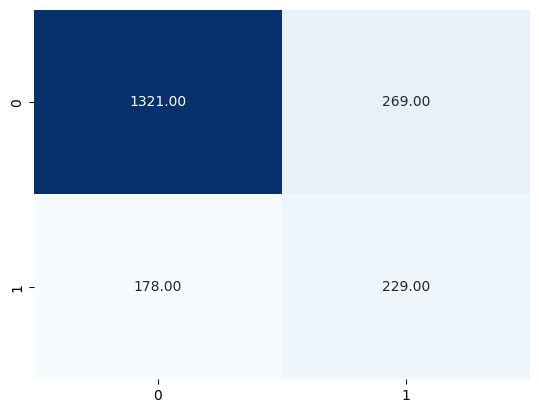

In [40]:
 sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred_test),cmap='Blues',cbar=False,annot=True,fmt='.2f')

* Random Forest

In [41]:
forest_clf = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42,class_weight=class_weights)
forest_clf.fit(X_train_processed,y_train)

y_pred_train = forest_clf.predict(X_train_processed)
y_pred_test = forest_clf.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the training set is : {score_test*100:.3f}")

F1 score of the training set is : 60.984
F1 score of the training set is : 59.459


In [42]:
forest_clf = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)
forest_clf.fit(X_train_resampled,y_train_resampled)

y_pred_train = forest_clf.predict(X_train_processed)
y_pred_test = forest_clf.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")

F1 score of the training set is : 61.744
F1 score of the test set is : 62.484


* Randomforest tunning

In [43]:
forest_base = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)

params_tunning = {
    'n_estimators' : np.arange(50,400,40),
    'max_depth' : np.arange(2,10,2)
}

grid_search=GridSearchCV(estimator=forest_base,param_grid=params_tunning,cv=5,n_jobs=-1,verbose=2,scoring='f1')
grid_search.fit(X_train_resampled,y_train_resampled)



Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': array([2, 4, 6, 8]), 'n_estimators': array([ 50, ...90, 330, 370])}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(90)


In [44]:
grid_search.best_score_ , grid_search.best_params_

(np.float64(0.8106963178609174),
 {'max_depth': np.int64(8), 'n_estimators': np.int64(90)})

In [45]:
forest_base = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)

params_tunning = {
    'n_estimators' : np.arange(50,400,40),
    'max_depth' : np.arange(6,18,2)
}

grid_search=GridSearchCV(estimator=forest_base,param_grid=params_tunning,cv=5,n_jobs=-1,verbose=2,scoring='f1')
grid_search.fit(X_train_resampled,y_train_resampled)



Fitting 5 folds for each of 54 candidates, totalling 270 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': array([ 6, 8..., 12, 14, 16]), 'n_estimators': array([ 50, ...90, 330, 370])}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(290)


In [46]:
grid_search.best_score_ , grid_search.best_params_

(np.float64(0.8558465715124589),
 {'max_depth': np.int64(16), 'n_estimators': np.int64(290)})

In [47]:
forest_base = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)

params_tunning = {
    'n_estimators' : np.arange(50,400,40),
    'max_depth' : np.arange(12,26,2)
}

grid_search=GridSearchCV(estimator=forest_base,param_grid=params_tunning,cv=5,n_jobs=-1,verbose=2,scoring='f1')
grid_search.fit(X_train_resampled,y_train_resampled)



Fitting 5 folds for each of 63 candidates, totalling 315 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': array([12, 14..., 20, 22, 24]), 'n_estimators': array([ 50, ...90, 330, 370])}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(330)


In [48]:
grid_search.best_score_ , grid_search.best_params_

(np.float64(0.8607425433411569),
 {'max_depth': np.int64(22), 'n_estimators': np.int64(330)})

In [49]:
forest_tunned = grid_search.best_estimator_

y_pred_train = forest_tunned.predict(X_train_processed)
y_pred_test = forest_tunned.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")


F1 score of the training set is : 100.000
F1 score of the test set is : 62.797


In [50]:
sum(y_train - forest_tunned.predict(X_train_processed))

0

In [51]:
random_forest_test = RandomForestClassifier(n_estimators=90,max_depth=8,random_state=42)
random_forest_test.fit(X_train_resampled,y_train_resampled)

y_pred_train = random_forest_test.predict(X_train_processed)
y_pred_test = random_forest_test.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")


F1 score of the training set is : 65.576
F1 score of the test set is : 63.118


In [52]:
forest_base = RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42,class_weight=class_weights)

params_tunning = {
    'n_estimators' : np.arange(50,400,40),
    'max_depth' : np.arange(6,18,2)
}

grid_search=GridSearchCV(estimator=forest_base,param_grid=params_tunning,cv=5,n_jobs=-1,verbose=2,scoring='f1')
grid_search.fit(X_train_processed,y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': array([ 6, 8..., 12, 14, 16]), 'n_estimators': array([ 50, ...90, 330, 370])}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(250)


In [53]:
grid_search.best_score_ , grid_search.best_params_

(np.float64(0.6216796472033506),
 {'max_depth': np.int64(8), 'n_estimators': np.int64(250)})

In [54]:
forest_tunned = grid_search.best_estimator_

y_pred_train = forest_tunned.predict(X_train_processed)
y_pred_test = forest_tunned.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")


F1 score of the training set is : 69.605
F1 score of the test set is : 61.290


In [55]:
feature_names = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
feature_names

['CreditScore',
 'Age',
 'Balance',
 'EstimatedSalary',
 'Gender_Male',
 'Geography_Germany',
 'Geography_Spain',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [56]:
feature_importance = pd.DataFrame(
    {'features' : feature_names , 
    'importance':forest_tunned.feature_importances_
    }).sort_values('importance',ascending=False)
feature_importance

,features,importance
1,Age,0.363101
8,NumOfProducts,0.243053
2,Balance,0.103231
10,IsActiveMember,0.066563
5,Geography_Germany,0.055883
3,EstimatedSalary,0.051079
0,CreditScore,0.050835
7,Tenure,0.027915
4,Gender_Male,0.024763
6,Geography_Spain,0.007124


In [57]:
joblib.dump(forest_tunned,filename=os.path.join(MODELS_FOLDER_PATH,'forest_tunned.pkl'))

['c:\\Users\\LOQ\\Desktop\\projects\\Agoor\\churn-modeling\\notebooks\\..\\Models\\forest_tunned.pkl']

* XGBOOST

In [58]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",max_depth = 5,
                             learning_rate =0.1 , random_state = 42 , n_estimators = 150)

xgb_clf.fit(X_train_processed,y_train)
y_pred_train = xgb_clf.predict(X_train_processed)
y_pred_test = xgb_clf.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")



F1 score of the training set is : 69.285
F1 score of the test set is : 61.718


In [59]:
scale = (y_train==0).sum() / (y_train==1).sum()
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights = class_weights/np.sum(class_weights)
class_weights = dict(zip(np.unique(y_train),class_weights))

sample_weights = np.array([class_weights[i] for i in y_train])

In [81]:
xgb_base = xgb.XGBClassifier(objective="binary:logistic",max_depth = 5,
                             learning_rate =0.1 , random_state = 42 , n_estimators = 150 ,reg_lambda = 1)

param_dict = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

random_search_xgb=RandomizedSearchCV(estimator=xgb_base,param_distributions=param_dict,
                   cv = 5 ,random_state=42,n_jobs=-1,n_iter = 300 , scoring='f1')
random_search_xgb.fit(X_train_processed,y_train,sample_weight=sample_weights)


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 3, ...], ...}"
,n_iter,300
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [82]:
xgb_tunned = random_search_xgb.best_estimator_
random_search_xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 7,
 'learning_rate': 0.01,
 'colsample_bytree': 0.6}

In [83]:
y_pred_train = xgb_tunned.predict(X_train_processed)
y_pred_test = xgb_tunned.predict(X_test_processed)

score_train = f1_score(y_train,y_pred_train)
score_test = f1_score(y_test,y_pred_test)

print(f"F1 score of the training set is : {score_train*100:.3f}")
print(f"F1 score of the test set is : {score_test*100:.3f}")

F1 score of the training set is : 65.729
F1 score of the test set is : 59.941


In [85]:
joblib.dump(xgb_tunned,os.path.join(MODELS_FOLDER_PATH,'xgb_tunned.pkl'))

['c:\\Users\\LOQ\\Desktop\\projects\\Agoor\\churn-modeling\\notebooks\\..\\Models\\xgb_tunned.pkl']

In [86]:
import secrets
secrets.token_hex(16)

'e17231b4c7520683f2a7d91625ba8dc6'

In [87]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
